# Machine learning notebook

The purpose of the following notebook is to train the machine learning algorithm and save it as a pickle file (app/model/model.pkl).
The data used for the Streamlit app will be saved to app/model/data.pkl as a pickle file.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import importlib
import config
importlib.reload(config)
from config import Config
from ast import literal_eval
config_file = Config()
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
import instrumentalness_categorizer
importlib.reload(instrumentalness_categorizer)
import label_calculator
importlib.reload(label_calculator)
import danceability_categorizer
importlib.reload(danceability_categorizer)
from instrumentalness_categorizer import InstrumentalnessCategorizer
from label_calculator import LabelCalculator
from danceability_categorizer import DanceabilityCategorizer
import energy_categorizer
importlib.reload(energy_categorizer)
from energy_categorizer import EnergyCategorizer
import valence_categorizer
importlib.reload(valence_categorizer)
from valence_categorizer import ValenceCategorizer
import recommender
importlib.reload(recommender)
from recommender import Recommender
import os
import pickle
from sklearn.model_selection import RandomizedSearchCV  
import warnings

In [2]:
warnings.filterwarnings('ignore')

## Import and clean preprocessed file 

In [3]:
def try_literal_eval(input_value, error_default):
    """Tries the literal evaluation to the input value and returns the error default if it fails.
    Args:
        input_value (_type_): The input value.
        error_default (_type_): The error default.
    Returns:
        _type_: The literal evaluation.
    """
    try:
        return literal_eval(input_value)
    except:
        return error_default

In [4]:
def clean_frame(preprocessed_data: pd.DataFrame) -> pd.DataFrame:
    """Cleans the data frame (type converting).
    Args:
        preprocessed_data (pd.DataFrame): The preprocessed frame.
    Raises:
        TypeError: Is thrown if preprocessed_data is not a pd.DataFrame.
    Returns:
        pd.DataFrame: The result frame.
    """
    if type(preprocessed_data) != pd.DataFrame:
        raise TypeError("preprocessed_data must be a DataFrame!")
    
    preprocessed_data["available_markets"] = preprocessed_data["available_markets"].apply(lambda x: try_literal_eval(x, []))
    preprocessed_data["track_genre"] = preprocessed_data["track_genre"].astype(str)
    preprocessed_data["artists_name"] = preprocessed_data["artists_name"].apply(lambda x: try_literal_eval(x, []))
    preprocessed_data["artists_followers"] = preprocessed_data["artists_followers"].apply(lambda x: try_literal_eval(x, {}))
    preprocessed_data["artists_popularity"] = preprocessed_data["artists_popularity"].apply(lambda x: try_literal_eval(x, {}))
    preprocessed_data["images"] = preprocessed_data["images"].apply(lambda x: try_literal_eval(x, {}))
    preprocessed_data["release_date"] = preprocessed_data["release_date"].astype("datetime64[ns]")
    return preprocessed_data

In [5]:
data = pd.read_csv(config_file.preprocessed_data_path, sep=",")

In [6]:
data_original = clean_frame(data)

In [7]:
data = pd.DataFrame(data_original)

In [8]:
data.columns

Index(['id', 'acousticness', 'available_markets', 'country', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness',
       'lyrics', 'mode', 'name', 'playlist', 'popularity', 'preview_url',
       'speechiness', 'tempo', 'time_signature', 'uri', 'valence',
       'track_genre', 'artists_name', 'artists_followers',
       'artists_popularity', 'images', 'album_name', 'release_date',
       'release_date_precision', 'mean_syllables_word', 'mean_words_sentence',
       'n_sentences', 'n_words', 'sentence_similarity', 'vocabulary_wealth'],
      dtype='object')

In [9]:
data['track_genre'].unique()

array(['other', 'pop', 'rock', 'r&b', 'jazz', 'punk', 'soul', 'rap',
       'hip hop', 'metal', 'country', 'experimental', 'folk',
       'avant-garde', 'blues', 'electronic', 'easy listening'],
      dtype=object)

## Check for NA values

Attributes **"valence"**, **"danceability"**, **"instrumentalness"** and **"energy"** will be used to train the algorithm.
The NA values has to be eliminated to prevent the algorithm from malfunctioning.

In [10]:
data[data["valence"].isna()]

Empty DataFrame
Columns: [id, acousticness, available_markets, country, danceability, duration_ms, energy, instrumentalness, liveness, loudness, lyrics, mode, name, playlist, popularity, preview_url, speechiness, tempo, time_signature, uri, valence, track_genre, artists_name, artists_followers, artists_popularity, images, album_name, release_date, release_date_precision, mean_syllables_word, mean_words_sentence, n_sentences, n_words, sentence_similarity, vocabulary_wealth]
Index: []

[0 rows x 35 columns]

In [11]:
data[data["danceability"].isna()]

Empty DataFrame
Columns: [id, acousticness, available_markets, country, danceability, duration_ms, energy, instrumentalness, liveness, loudness, lyrics, mode, name, playlist, popularity, preview_url, speechiness, tempo, time_signature, uri, valence, track_genre, artists_name, artists_followers, artists_popularity, images, album_name, release_date, release_date_precision, mean_syllables_word, mean_words_sentence, n_sentences, n_words, sentence_similarity, vocabulary_wealth]
Index: []

[0 rows x 35 columns]

In [12]:
data[data["instrumentalness"].isna()]

Empty DataFrame
Columns: [id, acousticness, available_markets, country, danceability, duration_ms, energy, instrumentalness, liveness, loudness, lyrics, mode, name, playlist, popularity, preview_url, speechiness, tempo, time_signature, uri, valence, track_genre, artists_name, artists_followers, artists_popularity, images, album_name, release_date, release_date_precision, mean_syllables_word, mean_words_sentence, n_sentences, n_words, sentence_similarity, vocabulary_wealth]
Index: []

[0 rows x 35 columns]

In [13]:
data[data["energy"].isna()]

Empty DataFrame
Columns: [id, acousticness, available_markets, country, danceability, duration_ms, energy, instrumentalness, liveness, loudness, lyrics, mode, name, playlist, popularity, preview_url, speechiness, tempo, time_signature, uri, valence, track_genre, artists_name, artists_followers, artists_popularity, images, album_name, release_date, release_date_precision, mean_syllables_word, mean_words_sentence, n_sentences, n_words, sentence_similarity, vocabulary_wealth]
Index: []

[0 rows x 35 columns]

It can be seen that no NA values are present in the mentioned attributes.

## Rescale, Create additional attributes

Although the popularity is not used for KNN, it is scaled using MIN-MAX scaling.

In [14]:
# Rescale the popularity for value between 0 and 1
data_popularity_min = data['popularity'].min()
data_popularity_max = data['popularity'].max()
data['popularity'] = data['popularity'].apply(lambda v: (v - data_popularity_min)/(data_popularity_max - data_popularity_min))

In [15]:
data[~((data["popularity"] >= 0) & (data["popularity"] <= 1))]

Empty DataFrame
Columns: [id, acousticness, available_markets, country, danceability, duration_ms, energy, instrumentalness, liveness, loudness, lyrics, mode, name, playlist, popularity, preview_url, speechiness, tempo, time_signature, uri, valence, track_genre, artists_name, artists_followers, artists_popularity, images, album_name, release_date, release_date_precision, mean_syllables_word, mean_words_sentence, n_sentences, n_words, sentence_similarity, vocabulary_wealth]
Index: []

[0 rows x 35 columns]

Since **"valence"**, **"danceability"**, **"instrumentalness"** and **"energy"** are already between 0 and 1, there is no need for them to be rescaled.

In [16]:
data[~((data["valence"] >= 0) & (data["valence"] <= 1))]

Empty DataFrame
Columns: [id, acousticness, available_markets, country, danceability, duration_ms, energy, instrumentalness, liveness, loudness, lyrics, mode, name, playlist, popularity, preview_url, speechiness, tempo, time_signature, uri, valence, track_genre, artists_name, artists_followers, artists_popularity, images, album_name, release_date, release_date_precision, mean_syllables_word, mean_words_sentence, n_sentences, n_words, sentence_similarity, vocabulary_wealth]
Index: []

[0 rows x 35 columns]

In [17]:
data[~((data["danceability"] >= 0) & (data["danceability"] <= 1))]

Empty DataFrame
Columns: [id, acousticness, available_markets, country, danceability, duration_ms, energy, instrumentalness, liveness, loudness, lyrics, mode, name, playlist, popularity, preview_url, speechiness, tempo, time_signature, uri, valence, track_genre, artists_name, artists_followers, artists_popularity, images, album_name, release_date, release_date_precision, mean_syllables_word, mean_words_sentence, n_sentences, n_words, sentence_similarity, vocabulary_wealth]
Index: []

[0 rows x 35 columns]

In [18]:
data[~((data["instrumentalness"] >= 0) & (data["instrumentalness"] <= 1))]

Empty DataFrame
Columns: [id, acousticness, available_markets, country, danceability, duration_ms, energy, instrumentalness, liveness, loudness, lyrics, mode, name, playlist, popularity, preview_url, speechiness, tempo, time_signature, uri, valence, track_genre, artists_name, artists_followers, artists_popularity, images, album_name, release_date, release_date_precision, mean_syllables_word, mean_words_sentence, n_sentences, n_words, sentence_similarity, vocabulary_wealth]
Index: []

[0 rows x 35 columns]

In [19]:
data[~((data["energy"] >= 0) & (data["energy"] <= 1))]

Empty DataFrame
Columns: [id, acousticness, available_markets, country, danceability, duration_ms, energy, instrumentalness, liveness, loudness, lyrics, mode, name, playlist, popularity, preview_url, speechiness, tempo, time_signature, uri, valence, track_genre, artists_name, artists_followers, artists_popularity, images, album_name, release_date, release_date_precision, mean_syllables_word, mean_words_sentence, n_sentences, n_words, sentence_similarity, vocabulary_wealth]
Index: []

[0 rows x 35 columns]

New category for rule-based clustering called "mood" is created by applying an algorithm that classifies using the following conditions:
* If valence < 0.25 => very negative
* If valence >= 0.25 and < 0.5 => negative
* If valence >= 0.5 and < 0.75 => positive
* If valence >= 0.75 and <= 1 => very positive

In [22]:
valence_categorizer = ValenceCategorizer()
data['mood'] = data['valence'].apply(lambda valence: valence_categorizer.categorize(valence))

In [23]:
data['mood'].unique()

array(['negative', 'positive', 'very positive', 'very negative'],
      dtype=object)

New category for rule-based clustering called "instrumentalness_category" is created by applying an algorithm that classifies using the following conditions:
* If instrumentalness < 0.25 => very low
* If instrumentalness >= 0.25 and < 0.5 => low
* If instrumentalness >= 0.5 and < 0.75 => high
* If instrumentalness >= 0.75 and <= 1 => very high

In [24]:
instrumentalness_categorizer = InstrumentalnessCategorizer()
data['instrumentalness_category'] = data['instrumentalness'].apply(lambda instr: instrumentalness_categorizer.categorize(instr))

In [25]:
data['instrumentalness_category'].unique()

array(['low', 'very low', 'very high', 'high'], dtype=object)

New category for rule-based clustering called "danceability_category" is created by applying an algorithm that classifies using the following conditions:
* If danceability < 0.25 => very undanceable
* If danceability >= 0.25 and < 0.5 => undanceable
* If danceability >= 0.5 and < 0.75 => danceable
* If danceability >= 0.75 and <= 1 => very danceable

In [26]:
danceability_categorizer = DanceabilityCategorizer()
data['danceability_category'] = data['danceability'].apply(lambda danceability: danceability_categorizer.categorize(danceability))

In [27]:
data['danceability_category'].unique()

array(['very danceable', 'danceable', 'undanceable', 'very undanceable'],
      dtype=object)

New category for rule-based clustering called "energy_category" is created by applying an algorithm that classifies using the following conditions:
* If energy < 0.25 => very low
* If energy >= 0.25 and < 0.5 => low
* If energy >= 0.5 and < 0.75 => high 
* If energy >= 0.75 and <= 1 => very high

In [28]:
energy_categorizer = EnergyCategorizer()
data['energy_category'] = data['energy'].apply(lambda energy: energy_categorizer.categorize(energy))

In [29]:
data['energy_category'].unique()

array(['high', 'low', 'very high', 'very low'], dtype=object)

Finally, the label is calculated using the following algorithm:
* Calculate digit indicating danceability category (0 = very undanceable, 1 = undanceable, 2 = danceable, 3 = very danceable)
* Calculate digit indicating instrumentalness category (0 = very low, 1 = low, 2 = high, 3 = very high)
* Calculate digit indicating mood category (0 = very negative, 1 = negative, 3 = positive, 4 = very positive)
* Calculate digit indicating energy category (0 = very low, 1 = low, 2 = high, 3 = very high)
* Construct a label of the following format: **&lt;danceability_digit>,&lt;instrumentalness_digit>,&lt;mood_digit,&lt;energy_digit**
* e.g. 0,0,1,2

In [30]:
label_calc = LabelCalculator()

In [31]:
data['label'] = data.apply(lambda frame: label_calc.calculate_label(frame['danceability_category'], 
                                                                    frame['instrumentalness_category'], 
                                                                    frame['mood'], 
                                                                    frame['energy_category']), axis=1)

In [32]:
data["label"].unique()

array(['3,1,1,2', '2,1,1,2', '1,0,2,2', '2,0,2,1', '2,0,3,3', '2,0,0,1',
       '2,0,1,2', '2,0,1,1', '2,1,1,3', '3,3,1,0', '1,3,0,3', '1,0,2,3',
       '2,3,3,3', '2,0,2,3', '2,0,1,0', '1,2,0,0', '1,0,0,3', '2,1,0,3',
       '2,0,0,2', '2,0,1,3', '3,0,1,2', '1,1,2,3', '2,0,0,3', '3,0,3,2',
       '3,0,2,2', '3,0,1,1', '3,0,0,2', '1,0,0,1', '0,0,1,1', '1,0,2,1',
       '2,0,3,1', '0,1,0,0', '0,3,1,3', '1,0,1,3', '3,0,3,3', '2,0,3,2',
       '2,1,1,0', '1,0,3,3', '1,0,1,2', '1,3,0,1', '3,0,2,1', '1,0,0,2',
       '3,0,2,3', '2,0,2,2', '1,3,0,0', '0,3,0,0', '2,3,0,1', '1,0,0,0',
       '3,2,2,3', '1,3,1,0', '2,0,0,0', '3,0,2,0', '0,0,0,0', '2,3,2,0',
       '1,0,1,1', '3,3,0,3', '0,2,0,1', '2,3,1,3', '0,3,0,1', '3,3,2,2',
       '2,2,3,3', '2,3,2,1', '2,3,1,1', '1,3,0,2', '2,3,2,3', '3,0,1,3',
       '0,2,0,0', '1,2,2,3', '2,2,0,2', '1,0,1,0', '0,3,0,3', '3,3,1,3',
       '0,2,0,3', '1,1,1,3', '0,0,0,3', '0,0,0,1', '2,3,1,0', '2,3,1,2',
       '3,0,1,0', '3,3,2,3', '2,2,0,3', '1,1,0,2', 

Amount of unique labels

In [42]:
len(data["label"].unique())

241

## Training the model

In [34]:
def plot_k_training_cycles(metric: str, algorithm: str, X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, limit: int):
    """Plots the different training cycles for different ks.
    Args:
        metric (str): The metric (e.g. "euclidean").
        algorithm (str): The algorithm (e.g. "algorithm").
        X_train (pd.DataFrame): The training data set (without label).
        y_train (pd.Series): The training data set (label only).
        X_test (pd.DataFrame): The test data set (without label).
        y_test (pd.Series): The test data set (label only).
        limit (int): The limit of the plot.
    Raises:
        TypeError: Is thrown if metric is not an int.
        TypeError: Is thrown if algorithm is not an int.
        TypeError: Is thrown if X_train is not a pd.DataFrame.
        TypeError: Is thrown if y_train is not a pd.Series.
        TypeError: Is thrown if X_test is not a pd.DataFrame.
        TypeError: Is thrown if y_test is not a pd.Series.
        TypeError: Is thrown if limit is not an int.
        ValueError: Is thrown if limit is less than 1.
    """
    if type(metric) != str:
        raise TypeError("metric must be a str!")
    if type(algorithm) != str:
        raise TypeError("algorithm must be a str!")
    if type(X_train) != pd.DataFrame:
        raise TypeError("X_train has to be a dataframe!")
    if type(y_train) != pd.Series:
        raise TypeError("y_train has to be a series!")
    if type(X_test) != pd.DataFrame:
        raise TypeError("X_test has to be a dataframe!")
    if type(y_test) != pd.Series:
        raise TypeError("y_test has to be a series!")
    if type(limit) != int:
        raise TypeError("limit must be an integer!")
    if limit < 1:
        raise ValueError("limit must be at least 1!")
    
    k_range = range(1,limit + 1)
    scores = []

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors = k, metric=metric, algorithm=algorithm)
        knn.fit(X_train, y_train)
        scores.append(knn.score(X_test, y_test))

    plt.figure()
    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.title("KNeighborsClassifier score for different values of k")
    plt.scatter(k_range, scores)
    plt.xticks(list(range(0,limit + 1,1)))

Separate KNN parameters from label

In [35]:
X = data[['danceability','valence', 'instrumentalness', 'energy']]
y = data['label']

Split the dataset

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Use randomized search to find the best parameters

In [37]:
knn_grid = {"n_neighbors": np.arange(1, 20, 1),
           "metric": ["minkowski", "euclidean"],
           "algorithm": ["auto", "ball_tree", "kd_tree", "brute"]}

knn_rn = RandomizedSearchCV(KNeighborsClassifier(),
                                param_distributions=knn_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

knn_rn.fit(X_train, y_train)

print(knn_rn.best_params_)
knn_rn.score(X_test, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'n_neighbors': 19, 'metric': 'minkowski', 'algorithm': 'auto'}


0.926584265254071

Create the classifier

In [38]:
neighbors = knn_rn.best_params_["n_neighbors"]
metric = knn_rn.best_params_["metric"]
algorithm = knn_rn.best_params_["algorithm"]
knn = KNeighborsClassifier(n_neighbors=neighbors, metric=metric, algorithm=algorithm)

Train

In [39]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=19)

In [40]:
knn.score(X_test, y_test)

0.926584265254071

Plot of all ks up to 20 with the chosen algorithm and metric

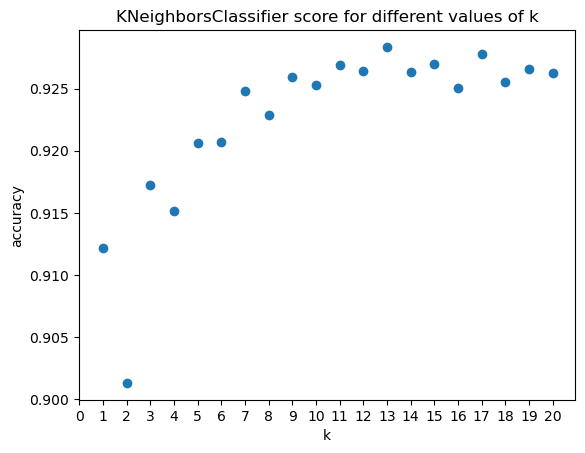

In [41]:
plot_k_training_cycles(metric, algorithm, X_train, y_train, X_test, y_test, 20)

## Plots of rule-based clusters 

Plot of scatter matrix for features used to train the model

array([[<Axes: xlabel='danceability', ylabel='danceability'>,
        <Axes: xlabel='valence', ylabel='danceability'>,
        <Axes: xlabel='instrumentalness', ylabel='danceability'>,
        <Axes: xlabel='energy', ylabel='danceability'>],
       [<Axes: xlabel='danceability', ylabel='valence'>,
        <Axes: xlabel='valence', ylabel='valence'>,
        <Axes: xlabel='instrumentalness', ylabel='valence'>,
        <Axes: xlabel='energy', ylabel='valence'>],
       [<Axes: xlabel='danceability', ylabel='instrumentalness'>,
        <Axes: xlabel='valence', ylabel='instrumentalness'>,
        <Axes: xlabel='instrumentalness', ylabel='instrumentalness'>,
        <Axes: xlabel='energy', ylabel='instrumentalness'>],
       [<Axes: xlabel='danceability', ylabel='energy'>,
        <Axes: xlabel='valence', ylabel='energy'>,
        <Axes: xlabel='instrumentalness', ylabel='energy'>,
        <Axes: xlabel='energy', ylabel='energy'>]], dtype=object)

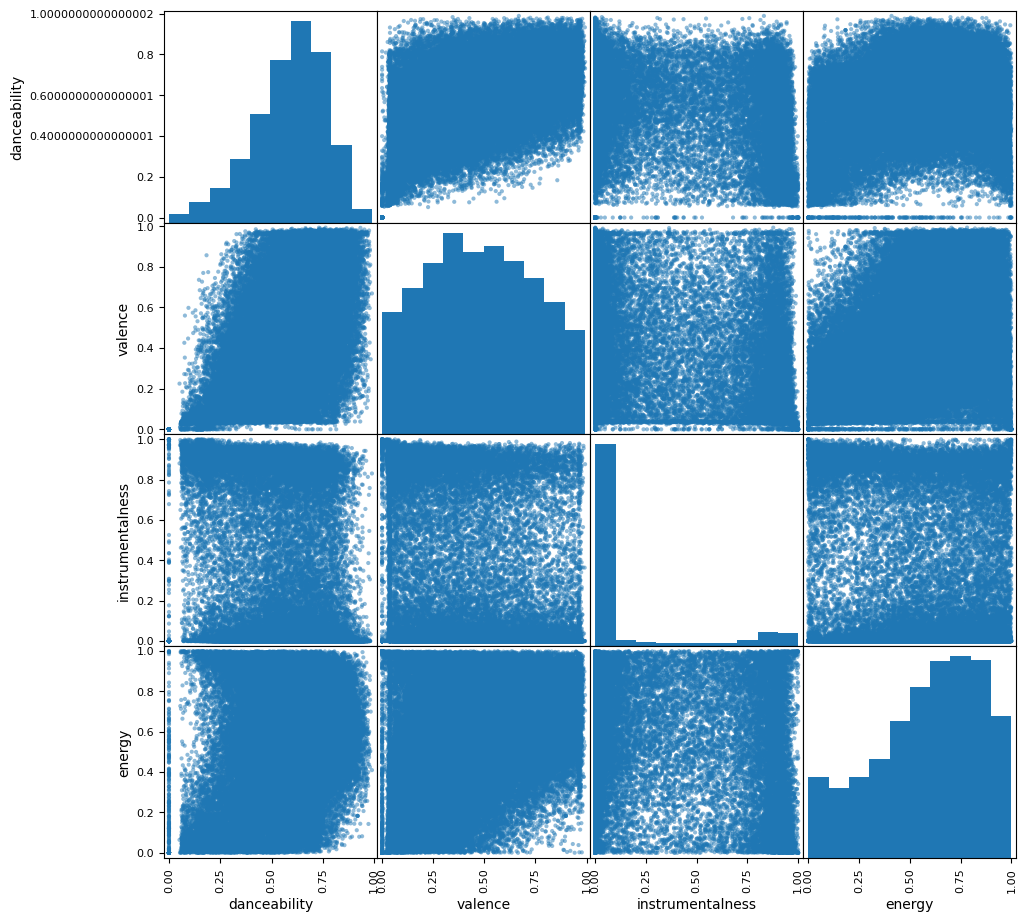

In [43]:
pd.plotting.scatter_matrix(X_train, figsize=[11,11])

In [44]:
def label_to_color(values: list, colors: list, input_value):
    """Converts a label to color.
    Args:
        values (list): List of unique label values.
        colors (list): List of colors.
        input_value (_type_): The input label value.
    Raises:
        TypeError: Is thrown if values is not a list.
        TypeError: Is thrown if colors is not a list.
        KeyError: Is thrown if input_value not in values.
    Returns:
        _type_: The correct color.
    """
    if type(values) != list:
        raise TypeError("values must be a list!")
    if type(colors) != list:
        raise TypeError("colors must be a list!")
    if input_value not in values:
        raise KeyError("input_value not present in values!")
    
    index = [i for i, v in enumerate(values) if v == input_value][0]
    return colors[index]

In [45]:
def get_colors(path: Path) -> list:
    """Gets colors used to plot the labels.
    Args:
        path (Path): The path to the colors.
    Raises:
        FileNotFoundError: Is thrown if the file under the path does not exist.
    Returns:
        list: List of the colors.
    """
    if not(os.path.exists(path)):
        raise FileNotFoundError("path could not be found!")
    with open(path, "r") as file:
        lines = [line.strip() for line in file]
    colors = ["#" + line for line in lines]
    return colors

In [46]:
colors = get_colors(config_file.colors_path)
values = list(data["label"].unique())
len(colors) == len(values)

True

In [47]:
test_to_plot = pd.DataFrame(X_test)
test_to_plot["label_predicted"] = knn.predict(test_to_plot)
test_to_plot["label"] = y_test
test_to_plot["label_predicted_colors"] = test_to_plot["label_predicted"].apply(lambda x: label_to_color(values, colors, x))
test_to_plot["label_colors"] = test_to_plot["label"].apply(lambda x: label_to_color(values, colors, x))

Scatter plot of the test set.

array([[<Axes: xlabel='danceability', ylabel='danceability'>,
        <Axes: xlabel='valence', ylabel='danceability'>,
        <Axes: xlabel='instrumentalness', ylabel='danceability'>,
        <Axes: xlabel='energy', ylabel='danceability'>],
       [<Axes: xlabel='danceability', ylabel='valence'>,
        <Axes: xlabel='valence', ylabel='valence'>,
        <Axes: xlabel='instrumentalness', ylabel='valence'>,
        <Axes: xlabel='energy', ylabel='valence'>],
       [<Axes: xlabel='danceability', ylabel='instrumentalness'>,
        <Axes: xlabel='valence', ylabel='instrumentalness'>,
        <Axes: xlabel='instrumentalness', ylabel='instrumentalness'>,
        <Axes: xlabel='energy', ylabel='instrumentalness'>],
       [<Axes: xlabel='danceability', ylabel='energy'>,
        <Axes: xlabel='valence', ylabel='energy'>,
        <Axes: xlabel='instrumentalness', ylabel='energy'>,
        <Axes: xlabel='energy', ylabel='energy'>]], dtype=object)

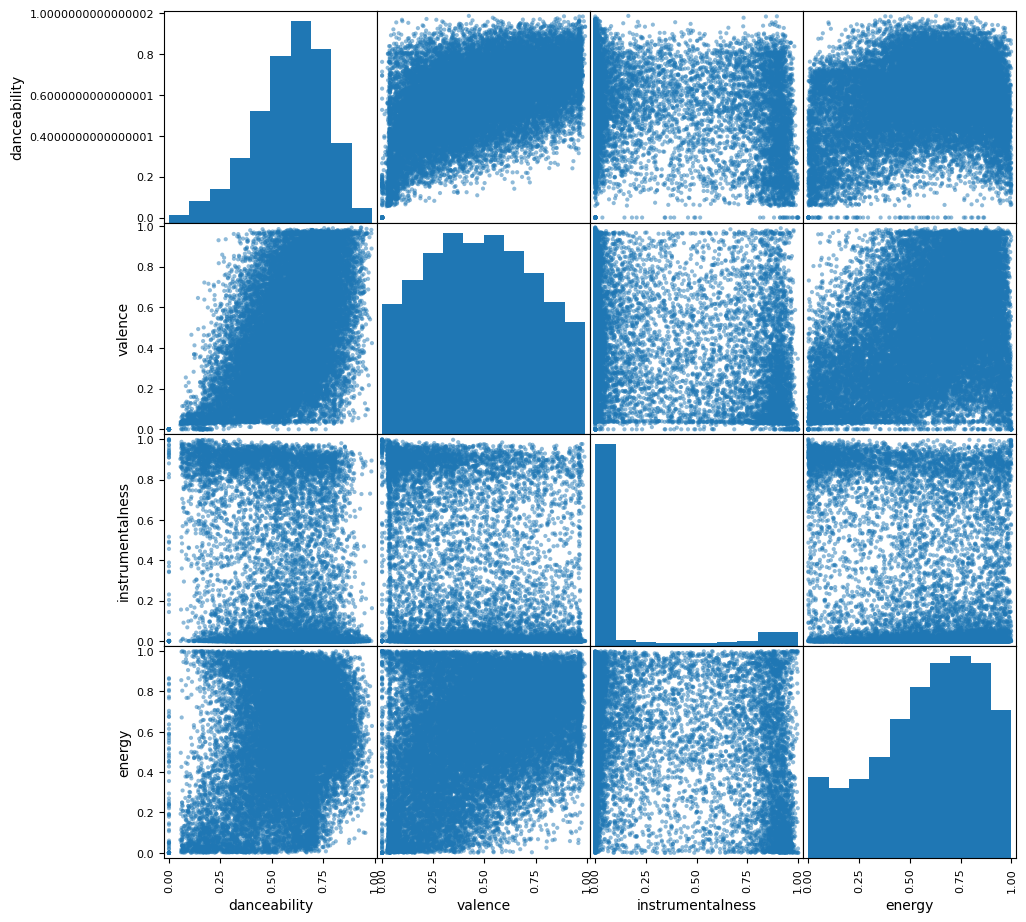

In [48]:
pd.plotting.scatter_matrix(test_to_plot, figsize=[11,11])

Scatter plot of the rule-based cluster labels (using manual labeling)

array([[<Axes: xlabel='danceability', ylabel='danceability'>,
        <Axes: xlabel='valence', ylabel='danceability'>,
        <Axes: xlabel='instrumentalness', ylabel='danceability'>,
        <Axes: xlabel='energy', ylabel='danceability'>],
       [<Axes: xlabel='danceability', ylabel='valence'>,
        <Axes: xlabel='valence', ylabel='valence'>,
        <Axes: xlabel='instrumentalness', ylabel='valence'>,
        <Axes: xlabel='energy', ylabel='valence'>],
       [<Axes: xlabel='danceability', ylabel='instrumentalness'>,
        <Axes: xlabel='valence', ylabel='instrumentalness'>,
        <Axes: xlabel='instrumentalness', ylabel='instrumentalness'>,
        <Axes: xlabel='energy', ylabel='instrumentalness'>],
       [<Axes: xlabel='danceability', ylabel='energy'>,
        <Axes: xlabel='valence', ylabel='energy'>,
        <Axes: xlabel='instrumentalness', ylabel='energy'>,
        <Axes: xlabel='energy', ylabel='energy'>]], dtype=object)

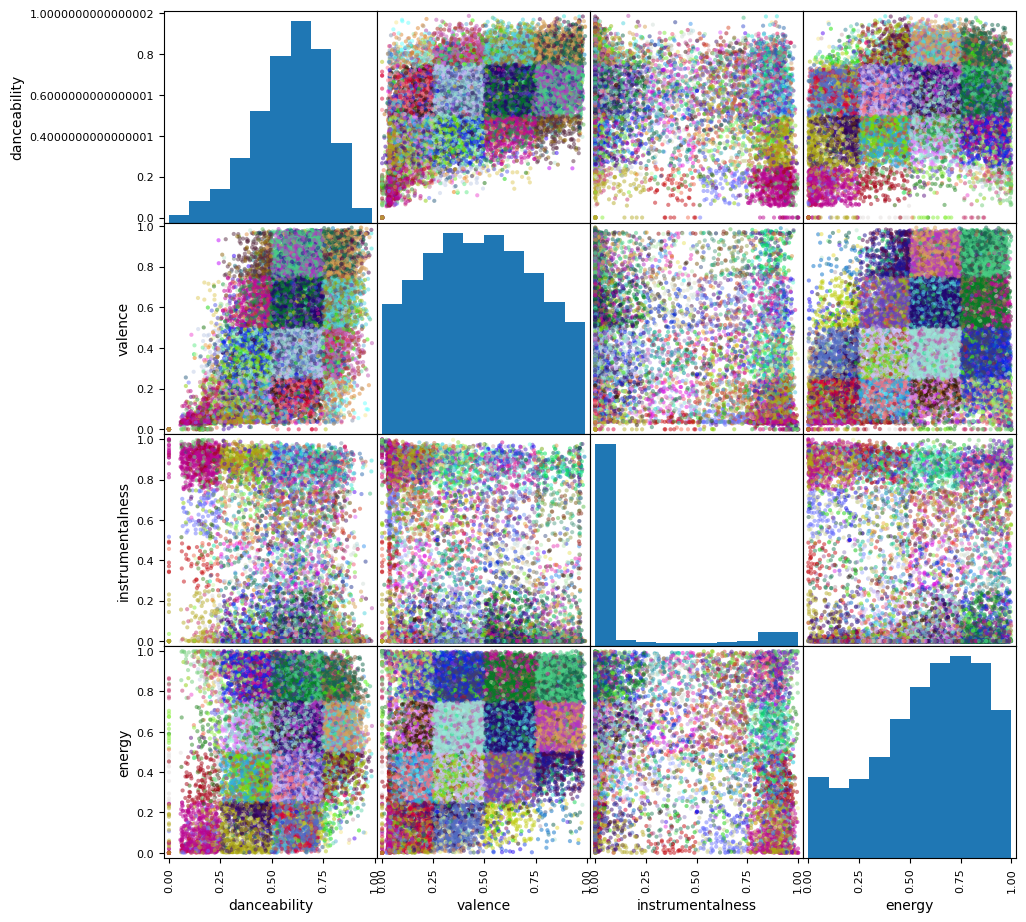

In [49]:
pd.plotting.scatter_matrix(test_to_plot, figsize=[11,11], c=test_to_plot["label_colors"])

Scatter plot of the rule-based cluster labels (using prediction)

array([[<Axes: xlabel='danceability', ylabel='danceability'>,
        <Axes: xlabel='valence', ylabel='danceability'>,
        <Axes: xlabel='instrumentalness', ylabel='danceability'>,
        <Axes: xlabel='energy', ylabel='danceability'>],
       [<Axes: xlabel='danceability', ylabel='valence'>,
        <Axes: xlabel='valence', ylabel='valence'>,
        <Axes: xlabel='instrumentalness', ylabel='valence'>,
        <Axes: xlabel='energy', ylabel='valence'>],
       [<Axes: xlabel='danceability', ylabel='instrumentalness'>,
        <Axes: xlabel='valence', ylabel='instrumentalness'>,
        <Axes: xlabel='instrumentalness', ylabel='instrumentalness'>,
        <Axes: xlabel='energy', ylabel='instrumentalness'>],
       [<Axes: xlabel='danceability', ylabel='energy'>,
        <Axes: xlabel='valence', ylabel='energy'>,
        <Axes: xlabel='instrumentalness', ylabel='energy'>,
        <Axes: xlabel='energy', ylabel='energy'>]], dtype=object)

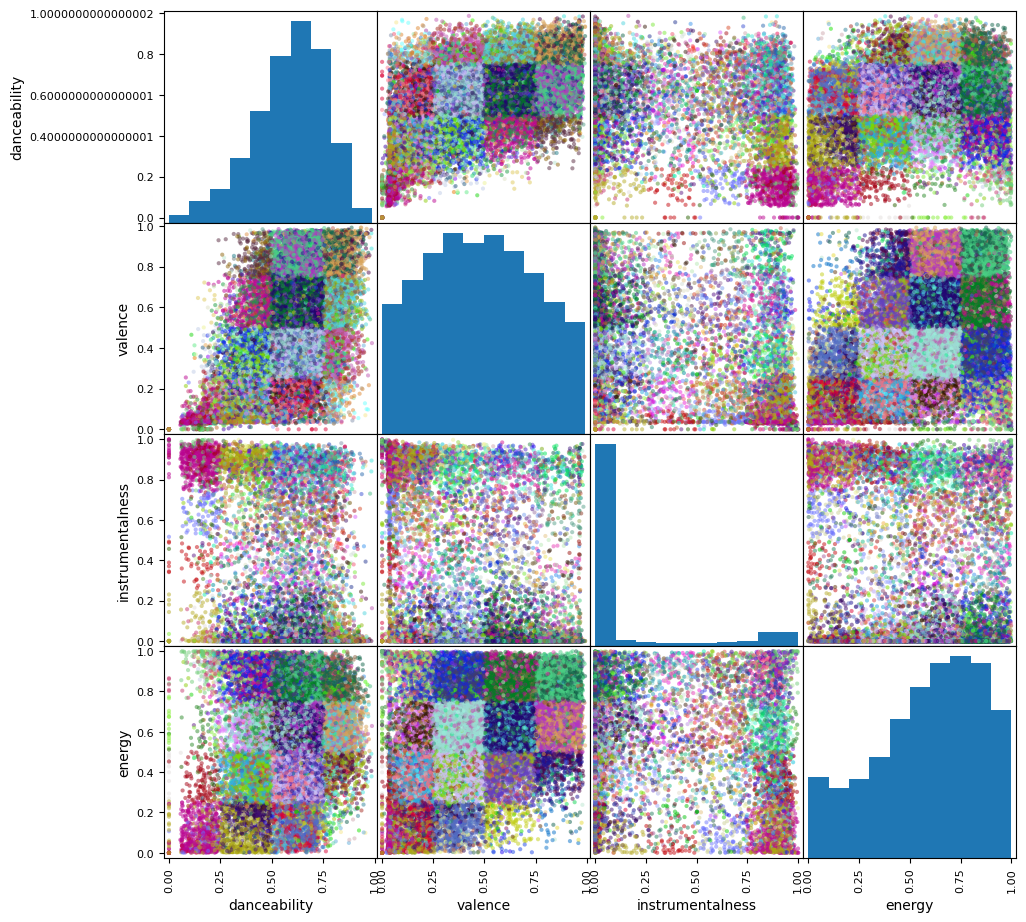

In [50]:
pd.plotting.scatter_matrix(test_to_plot, figsize=[11,11], c=test_to_plot["label_predicted_colors"])

You can see the clusters created using the rule-based labeling. 
Due to the high accuracy (93 %) the both label comparison plots are similar.

## Conclusion 
Genre could not be chosen as label because it strongly varies and it cannot be unambiguously defined what is valid danceability range for e.g. jazz.
Therefore, danceability, valence, instrumentalness and energy were chosen to train the model.
These are attributes that influence the taste of the listener the most.
The specific genre must be filtered out. </br>
Example:

In [51]:
prediction = knn.predict([[0.9,0.533, 0.874000, 0.960]])
prediction

array(['3,3,2,3'], dtype=object)

In [52]:
decomposed = label_calc.decompose_label(prediction[0])
decomposed

{'danceability': 'very danceable',
 'instrumentalness': 'very high',
 'mood': 'positive',
 'energy': 'very high'}

Example recommendations

In [53]:
prediction = knn.predict([[0.442,0.533, 0.874000, 0.960]])
prediction

array(['1,3,2,3'], dtype=object)

In [54]:
decomposed = label_calc.decompose_label(prediction[0])
decomposed

{'danceability': 'undanceable',
 'instrumentalness': 'very high',
 'mood': 'positive',
 'energy': 'very high'}

Recommended in general:

In [55]:
recommender = Recommender()
recommended = recommender.recommend(decomposed['danceability'], decomposed['mood'], decomposed['energy'], decomposed['instrumentalness'], data)
recommended

id  acousticness  \
1804    2mwnYvlLVP465u9V9wjUGj      0.000136   
2401    2tbPqkS9tcRaT8CboQEm32      0.000007   
2840    7zmx0jIZRjZ2fSOYqByKNa      0.004190   
2887    30SHFV4ikLGdh74X4uoTLC      0.000518   
3956    2QjV41OeVYt1PtvLwL6l38      0.006870   
...                        ...           ...   
96289   2fgjZEZ0NlwoPvUMfvVzUP      0.014400   
96775   4XoLM5pbS7zLx5NbL4v790      0.000847   
98360   4gE0qgEcL3lxiiCnnenhC4      0.002050   
98644   1UNkCY2v2hOUeoiJZMtX6C      0.009480   
100793  3pYiZe0qoZBmJqqqBmXwFm      0.000053   

                                        available_markets country  \
1804    [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...      FI   
2401    [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...      BE   
2840    [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...      AR   
2887    [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...      FI   
3956    [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...      FI   
...                                                   ...     ...   
96289   [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...      AR   
96775   [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...      BE   
98360   [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...      FI   
98644   [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...      AR   
100793  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...      FI   

        danceability  duration_ms  energy  instrumentalness  liveness  \
1804           0.400     245573.0   0.946             0.853     0.155   
2401           0.422     197171.0   0.948             0.915     0.248   
2840           0.473     210000.0   0.833             0.907     0.266   
2887           0.409     189701.0   0.994             0.966     0.336   
3956           0.498     226000.0   0.898             0.863     0.403   
...              ...          ...     ...               ...       ...   
96289          0.432     356760.0   0.797             0.755     0.310   
96775          0.392     167518.0   0.752             0.891     0.152   
98360          0.393     529778.0   0.901             0.835     0.312   
98644          0.389     174413.0   0.922             0.925     0.126   
100793         0.265     191852.0   0.794             0.864     0.178   

        loudness  ... mean_words_sentence  n_sentences n_words  \
1804      -3.966  ...                -1.0         -1.0    -1.0   
2401      -5.493  ...                -1.0         -1.0    -1.0   
2840     -10.266  ...                -1.0         -1.0    -1.0   
2887      -5.889  ...                -1.0         -1.0    -1.0   
3956      -5.530  ...                -1.0         -1.0    -1.0   
...          ...  ...                 ...          ...     ...   
96289    -10.302  ...                -1.0         -1.0    -1.0   
96775     -7.338  ...                -1.0         -1.0    -1.0   
98360     -3.291  ...                -1.0         -1.0    -1.0   
98644     -6.493  ...                -1.0         -1.0    -1.0   
100793    -5.047  ...                -1.0         -1.0    -1.0   

       sentence_similarity  vocabulary_wealth      mood  \
1804                  -1.0               -1.0  positive   
2401                  -1.0               -1.0  positive   
2840                  -1.0               -1.0  positive   
2887                  -1.0               -1.0  positive   
3956                  -1.0               -1.0  positive   
...                    ...                ...       ...   
96289                 -1.0               -1.0  positive   
96775                 -1.0               -1.0  positive   
98360                 -1.0               -1.0  positive   
98644                 -1.0               -1.0  positive   
100793                -1.0               -1.0  positive   

        instrumentalness_category  danceability_category  energy_category  \
1804                    very high            undanceable        very high   
2401                    very high            undanceable        very high   
2840        

Recommended in genre jazz:

In [56]:
recommended[recommended['track_genre'] == 'jazz']

id  acousticness  \
44667  5MB24nrYX4rn7mZE9IQlP1        0.4710   
54860  0fDrAO5XentyidBRliT6o4        0.3750   
69677  1BYVhbLZ6PAsv36Gc8iPuK        0.0274   
96289  2fgjZEZ0NlwoPvUMfvVzUP        0.0144   

                                       available_markets country  \
44667  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...      FI   
54860  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...      AR   
69677  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...      BE   
96289  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...      AR   

       danceability  duration_ms  energy  instrumentalness  liveness  \
44667         0.361     353320.0   0.799             0.892     0.103   
54860         0.342     408627.0   0.819             0.924     0.114   
69677         0.376     589787.0   0.804             0.784     0.282   
96289         0.432     356760.0   0.797             0.755     0.310   

       loudness  ... mean_words_sentence  n_sentences n_words  \
44667    -9.483  ...                -1.0         -1.0    -1.0   
54860    -8.113  ...                -1.0         -1.0    -1.0   
69677    -8.591  ...                -1.0         -1.0    -1.0   
96289   -10.302  ...                -1.0         -1.0    -1.0   

      sentence_similarity  vocabulary_wealth      mood  \
44667                -1.0               -1.0  positive   
54860                -1.0               -1.0  positive   
69677                -1.0               -1.0  positive   
96289                -1.0               -1.0  positive   

       instrumentalness_category  danceability_category  energy_category  \
44667                  very high            undanceable        very high   
54860                  very high            undanceable        very high   
69677                  very high            undanceable        very high   
96289                  very high            undanceable        very high   

         label  
44667  1,3,2,3  
54860  1,3,2,3  
69677  1,3,2,3  
96289  1,3,2,3  

[4 rows x 40 columns]

## Store the model

In [57]:
pickle.dump(knn, open(config_file.model_path, "wb"))

## Store the data frame

In [58]:
pickle.dump(data_original, open(config_file.data_frame_path, "wb"))